<!-- dom:TITLE: STAT 5102 Regression in Practice Final Project -->
# <center>Generalised Linear Model for Estimating Mortality Rate Using Development Indicators</center>

---

<!-- dom:AUTHOR: CHAN, Yiu Fung Frankie, 1155010561 -->
<!-- Author: -->  
**<h5><center>CHAN, Yiu Fung Frankie,  1155010561</center></h5>**  
<!-- dom:AUTHOR: LI Wai Lan, 1155118254 -->
<!-- Author: -->  
**<h5><center>LI Wai Lan,  1155118254</center></h5>** 
<!-- dom:AUTHOR: WONG, Tsz Wing, 1004666311 -->
<!-- Author: -->  
**<h5><center>WONG, Tsz Wing,  1004666311</center></h5>**
<!-- dom:AUTHOR: WONG, Yiu Chung, 1155017920 -->
<!-- Author: -->  
**<h5><center>WONG, Yiu Chung,  1155017920</center></h5>** 


Date: **Dec 12, 2018**

In this study, we investigate the dataset obtained from The World Bank: World Development Indicators. A Generalised Linear Model is used to perform a prediction analysis on the response variable: Mortality rate, using ???(number) predictor variables.

In [0]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

In [0]:
#An integer for any random process that accepts a seed.
STAT5102 = 5102

In [0]:
#some self defined functions

def calculate_mse(y_true, y_pred, n, k):
    resid = (y_true - y_pred)
    rss = np.sum(resid**2)
    mse = rss / (n - (k + 1))
    return mse

# Import data

---



In [0]:
#change working directory to 5102 project folder
from sys import platform
from os import chdir

CURRENT_OS = platform
if CURRENT_OS == "darwin": #MacOS
    chdir(r"/Users/chung/Google Drive/2018R1 Regression in Practice (STAT5102)/5012 Project")
elif CURRENT_OS == "linux": #Google Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    %cd 'gdrive/My Drive/2018R1 Regression in Practice (STAT5102)/5012 Project'


In [0]:
#read project_data.sas7bdat
world_bank = pd.read_sas(r"project_data.sas7bdat", encoding="utf-8")

# Preliminary data wrangling 

---



First we remove a few variables:

*  Year
*  YearCode
*  Country Name
*  Country Code

In [0]:
#Drop the column Year and YearCode
world_bank.drop(["Year", "YearCode", "Country Name", "Country Code"], axis=1, inplace = True)

The variable "Age dependency ratio (% of working-age population)" includes people who are below 15 or above than 64. Mean while, the variable "Age dependency ratio, young (% of working-age population)" only includes people below 15. To seperate these two, we will subtract the seond from the first.
The original "Age dependency ratio (% of working-age population)" is renamed to "Age dependency ratio (% of working-age population)".

In [0]:
#Age dependency ratio (% of working-age population) includes people who are below 15 or above than 64
#Age dependency ratio, young (% of working-age population) only includes people below 15
#hence the first one includes redundant information

world_bank.rename(index = str, columns={"Age dependency ratio (% of worki": "Age dependency ratio, old",
                                       "Age dependency ratio, young (% o": "Age dependency ratio, young"},
                 inplace = True)

world_bank["Age dependency ratio, old"] -= world_bank["Age dependency ratio, young"]

In [0]:
show_all = 0
if show_all:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(world_bank)
else:
    display(world_bank.head())

,ARI treatment (% of children und,Adjusted savings: education expe,Adolescent fertility rate (birth,"Age dependency ratio, old","Age dependency ratio, young",Agricultural land (% of land are,"Birth rate, crude (per 1,000 peo",CPIA gender equality rating (1=l,"Central government debt, total (",Children with fever receiving an,...,"Life expectancy at birth, total","Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p",Population growth (annual %),"Immunization, DPT (% of children","Immunization, measles (% of chil","Physicians (per 1,000 people)",Women's share of population ages
0,NaN,NaN,99.095600,4.397600,98.722026,58.123668,37.952,2.0,NaN,NaN,...,59.600098,74.3,103.7,100.4,106.7,2.458417,66.0,62.0,0.194,35.4
1,NaN,2.842804,16.994600,15.062236,34.036210,43.843066,12.607,NaN,NaN,NaN,...,76.978512,16.1,18.1,16.3,19.7,-0.033072,99.0,99.0,1.153,NaN
2,NaN,4.467196,9.894599,6.945180,39.796430,17.370914,24.514,NaN,NaN,NaN,...,70.616610,18.4,21.5,19.0,23.8,1.850438,95.0,95.0,1.207,66.4
3,NaN,NaN,NaN,NaN,NaN,24.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.088667,NaN,NaN,NaN,NaN
4,NaN,2.889150,NaN,NaN,NaN,42.765957,9.800,NaN,NaN,NaN,...,NaN,2.9,3.5,3.1,3.8,-0.960625,99.0,99.0,3.912,NaN


# Missing data

---



The data set contains some obviously problematic data. For instance, some variables contains more then 90% missing data. Here, we remove variables with  more than 5% missing data, and remove cases with more than 5 missing points.

### First remove obviously problematic columns and observations

In [0]:
#remove case where Mortality rate, under-5 (per 1,000 live births) is Nan
world_bank = world_bank.loc[world_bank["Mortality rate, under-5 (per 1,0"].notnull(),:] 

#remove columns with more than 5% Nan
na_portion = world_bank.isna().sum() / len(world_bank)
world_bank = world_bank.loc[:, na_portion < .05]

#remove cases where there are 10 or more Nan
world_bank = world_bank[world_bank.isnull().sum(axis=1) < 5]

In [0]:
world_bank.shape

(184, 19)

## Multiple Imputation by Chained Equations (MICE)

- Read the following articles,
  1. [Multiple Imputation by Chained Equations: What is it and how does it work?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/) 
  1. [Missing Data Conundrum: Exploration and Imputation Techniques](https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87) 
  1. [Handling Missing Values in Machine Learning: Part 2](https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e)
  1. [fancyimpute](https://github.com/iskandr/fancyimpute)

- The draw backs of some other imputation techniques that we aren't using (e.g. mean)
- What is MICE, what is it trying to achieve
- How does MICE work?
- In what way does MICE outperform other techniques
- Does MICE rely on any assumptions (e.g. missing data are Missing at Random (MAR)好似係，除非唔係)

In [0]:
try:
    from fancyimpute import IterativeImputer
except ModuleNotFoundError as no_fancyimpute:
    print(ModuleNotFoundError)
    assert CURRENT_OS == "linux", "You are neither on Colab or have fancyimpute installed!!!"
    print("Now installing fancyimpute")
    !pip install -q fancyimpute 
    from fancyimpute import IterativeImputer
finally: 
    XY_incomplete = world_bank.copy()

    #fancy impute removes column names.
    train_cols = list(XY_incomplete)

    n_imputations = 100 #I wanted to use STAT5102 here, but looping 5102 times takes wayyyyyy too long.
    XY_completed = []
    for i in range(n_imputations):
        imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
        XY_completed.append(imputer.fit_transform(XY_incomplete))

    XY_completed_mean = np.mean(XY_completed, 0)
    XY_completed_std = np.std(XY_completed, 0)

    worldbank_imputed = pd.DataFrame(XY_completed_mean)
    worldbank_imputed.columns = train_cols
    assert not(worldbank_imputed.isnull().values.any())

Using TensorFlow backend.


In [0]:
#export world_bank to excel file to share with groupmates (19 Nov 2018)
share = 0
if share:
    writer = pd.ExcelWriter('worldbank_imputed.xlsx')
    worldbank_imputed.to_excel(writer, 'Sheet1')
    writer.save()

In [0]:
#!pip install -q openpyxl

In [0]:
#Remove outliner

# Exploratory Data Analysis

---

## Correlation heatmap

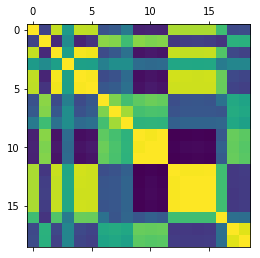

In [0]:
corr = worldbank_imputed.corr()
plt.matshow(worldbank_imputed.corr())

## Plotting distributions of numeric variables

我都唔係好知做呢part做乜@@


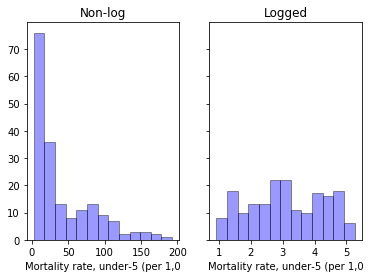

In [0]:
plot_data = worldbank_imputed["Mortality rate, under-5 (per 1,0"].copy()
plot_data_log = plot_data.apply(np.log)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title("Non-log")
ax2.set_title("Logged")

plot_1 = sns.distplot(plot_data, hist=True, kde=False,
                      bins=int(plot_data.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax1)

plot_2 = sns.distplot(plot_data_log, hist=True, kde=False,
                      bins=int(plot_data_log.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax2)

# Exploring correlations with OLS regression

Not all variables are useful in the dataset. Some might be highly correlated with each other and thus create redundency and colinearity/multicolinearity.

Let's start by looking at the response variable, i.e. the Mortality rates

In [0]:
mortality_rates = list(worldbank_imputed.columns)
mortality_rates = [item for item in mortality_rates if item.startswith('Mortality')]
corr = worldbank_imputed[mortality_rates].corr()
corr.style.background_gradient(low=.9)

,"Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p"
"Mortality rate, infant (per 1,00",1,0.984806,0.982479,0.986188
"Mortality rate, under-5 (per 1,0",0.984806,1,0.999571,0.999683
"Mortality rate, under-5, female",0.982479,0.999571,1,0.998518
"Mortality rate, under-5, male (p",0.986188,0.999683,0.998518,1


We see that everything is highly corrrelated; they are essentially the same measure. Highly correlated predictors can lead to instability in our estimator, as well as increased variance. 

Not only do these variables covary, their vaule are also extremely close to each other. It is very tempting for us to just use a single one of these variables to predict our response variable. Let's do this and see what's gonna happen if we just pick one of these predictors to predict Mortality rate, under-5 (per 1,000 births)? Here we use Mortality rate, infant (per 1,000 births).

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(worldbank_imputed["Mortality rate, infant (per 1,00"].values, 
                                                    worldbank_imputed["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
#fitted_values = lm.predict(X_test)
#residuals = y_test - fitted_values
fitted_values = lm.predict(X_train)
residuals = y_train - fitted_values
residuals = residuals.flatten()

In [0]:
X = X_train
X = sm.add_constant(X)
Y = y_train
lm2 = sm.OLS(Y, X).fit()
print(lm2.summary(xname=["Intercept", "Infant Mortality Rate"], yname = "U5 Mortality Rate"))

print("===============================================================================================================")

N = lm2.nobs
P = lm2.df_model
dfn, dfd = P, N - P - 1
F = lm2.mse_model / lm2.mse_resid
p = 1.0 - scipy.stats.f.cdf(F,dfn,dfd)
print(f'F-statistic: {F:.3f},  p-value: {p:.5f}')

                            OLS Regression Results                            
Dep. Variable:      U5 Mortality Rate   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4411.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):          1.90e-110
Time:                        17:27:03   Log-Likelihood:                -506.97
No. Observations:                 147   AIC:                             1018.
Df Residuals:                     145   BIC:                             1024.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.20

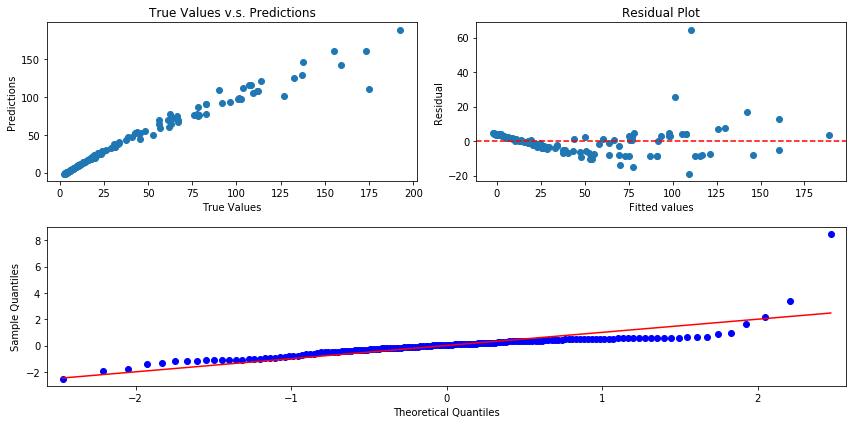

Test R^2: 0.9765002634085019
Test MSE: 44.1508558004016


In [0]:
from sklearn.metrics import mean_squared_error

fig = plt.figure(figsize = (12,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_train, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")


sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

print("Test R^2: " + str(lm.score(X = X_test, y = y_test)))
print("Test MSE: " + str(calculate_mse(y_test, lm.predict(X_test), X_test.shape[0], X_test.shape[1])))

### Normality Test

The residual plot is showing some mild fan shape pattern: the error does not remain constant along with the fitted values. This suggests either heteroscedasticity and/or nonlinear relationship between predictor and outcome. Let's perform a normality test for more percise asumption checking.

In [0]:
from scipy.stats import shapiro

# normality test
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.68106, p=1.8955e-16
Sample does not look Gaussian (reject H0)


In [0]:
from scipy.stats import kstest

stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.34851, p=2.2204e-16
Sample does not look Gaussian (reject H0)


In [0]:
from scipy.stats import anderson

result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print(f'Alpha at {sl/100}; Critical Value is:  {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is:  {cv}, data does not look Gaussian (reject H0)')

Statistic: 7.44196070779924
Alpha at 0.15; Critical Value is:  0.561, data does not look Gaussian (reject H0)
Alpha at 0.1; Critical Value is:  0.639, data does not look Gaussian (reject H0)
Alpha at 0.05; Critical Value is:  0.767, data does not look Gaussian (reject H0)
Alpha at 0.025; Critical Value is:  0.895, data does not look Gaussian (reject H0)
Alpha at 0.01; Critical Value is:  1.064, data does not look Gaussian (reject H0)


### Heteroskedasticity test

In [0]:
from statsmodels.stats.diagnostic import het_breuschpagan
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if f_pvalue > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 11.487, p = 0.0009013
Variance does not look constant (reject H0)


None of the Normality test passed.

The bottom line is, we cannot use Simple Linear Regression (OLS) simply because high correlation between predictor and outcome. We will not further investigate OLS in this report. 

How about the other two mortality indicators? After some eyeball investigation, it is not difficult to see that our response variable is merely the average of Male/Female mortality rate. Hence we will not include these two into our analysis because they are essentially the same thing as our response variable; they should not be included in any formal analysis because one could argue that this is a form of data leakage. However, it might be interesting to see how the DIFFERENCE in Male/Female mortality rate affects our response variable. Therefore we can consider adding the DIFFERENCE in Male/Female mortality rate into our dataset.

Finally, because of the following:
- infant mortality rate is highly correlated to our response
- they are measured in the same unit
- almost no difference in absolute value
- domain knowledge tell us that they are indeed almost the same measure

we decide to remove infant mortality rate.

In [0]:
Mortality_gender_diff = (worldbank_imputed["Mortality rate, under-5, male (p"] -
                         worldbank_imputed["Mortality rate, under-5, female"]).abs()
#add gender difference
worldbank_imputed.insert(12, "Mortality rate, under-5, Gender Difference", Mortality_gender_diff) 
#remove mortality rate for male and female
worldbank_imputed.drop(["Mortality rate, under-5, male (p", "Mortality rate, under-5, female"], axis=1,inplace=True)
#remove infant mortality rate
worldbank_imputed.drop(["Mortality rate, infant (per 1,00"], axis = 1, inplace = True)


We do the same thing for Life Expectancy: We combind "Life expectancy at birth", both male and female, and generate a new variable called ""Life expectancy at birth, Gender difference".

In [0]:
#do the same thing for Life expectancy 
Life_expt_gender_diff = (worldbank_imputed["Life expectancy at birth, female"] -
                         worldbank_imputed["Life expectancy at birth, male ("]).abs()
#add gender difference
worldbank_imputed.insert(10, "Life expectancy at birth, Gender Difference", Life_expt_gender_diff) 
#remove Life expectency for male and female
worldbank_imputed.drop(["Life expectancy at birth, female", "Life expectancy at birth, male ("], axis=1,inplace=True)

# Multiple Regression

Perhapes a set of predictor variables can better explain the variations in Mortality rate?

In [0]:
multi_reg_data = worldbank_imputed.copy()
X_train, X_test, y_train, y_test = train_test_split(multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1), 
                                                    multi_reg_data["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
# fitted_values = lm.predict(X_test)
# residuals = y_test - fitted_values
# residuals = residuals.flatten()
fitted_values = lm.predict(X_train)
residuals = y_train - fitted_values
residuals = residuals.flatten()

In [0]:
X = X_train
X = sm.add_constant(X)
Y = y_train
lm2 = sm.OLS(Y, X).fit()

xnames = ["Intercept"] + list(multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1).columns)
print(lm2.summary(xname=xnames, yname = "U5 Mortality Rate"))

print("===============================================================================================================")

N = lm2.nobs
P = lm2.df_model
dfn, dfd = P, N - P - 1
F = lm2.mse_model / lm2.mse_resid
p = 1.0 - scipy.stats.f.cdf(F,dfn,dfd)
print(f'F-statistic: {F:.3f},  p-value: {p:.5f}')

                            OLS Regression Results                            
Dep. Variable:      U5 Mortality Rate   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     105.0
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           2.79e-65
Time:                        17:27:03   Log-Likelihood:                -571.69
No. Observations:                 147   AIC:                             1175.
Df Residuals:                     131   BIC:                             1223.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

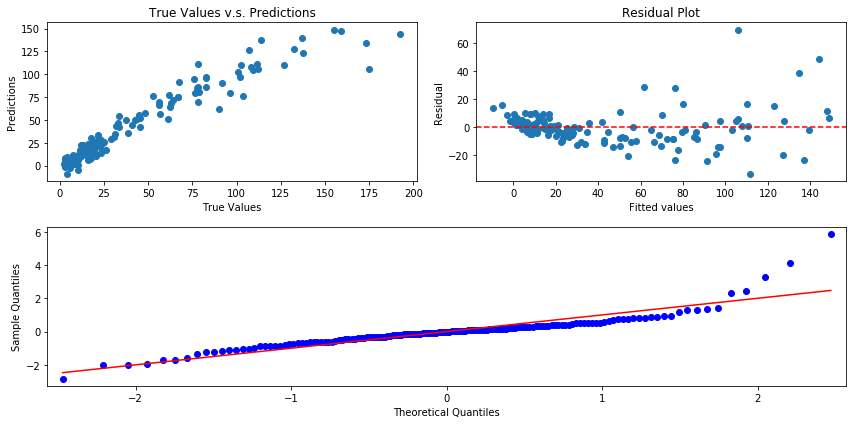

Test R^2: 0.932414827954037
Test MSE: 211.629548387236


In [0]:
fig = plt.figure(figsize = (12,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_train, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

print("Test R^2: " + str(lm.score(X = X_test, y = y_test)))
print("Test MSE: " + str(calculate_mse(y_test, lm.predict(X_test), X_test.shape[0], X_test.shape[1])))

### Normality Tests

In [0]:
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.85039, p=6.3478e-11
Sample does not look Gaussian (reject H0)


In [0]:
stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.37405, p=0.0
Sample does not look Gaussian (reject H0)


In [0]:
result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print(f'Alpha at {sl/100}: Critical Value is: {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is: {cv}, data does not look Gaussian (reject H0)')

Statistic: 4.404153076070486
Alpha at 0.15; Critical Value is: 0.561, data does not look Gaussian (reject H0)
Alpha at 0.1; Critical Value is: 0.639, data does not look Gaussian (reject H0)
Alpha at 0.05; Critical Value is: 0.767, data does not look Gaussian (reject H0)
Alpha at 0.025; Critical Value is: 0.895, data does not look Gaussian (reject H0)
Alpha at 0.01; Critical Value is: 1.064, data does not look Gaussian (reject H0)


Other than setting alpha at 0.01 in an Anderson-Darling test, every other tests yields result suggesting non-normality in the residuals. 

### Heteroskedasticity test


In [0]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if f_pvalue > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 37.289, p = 8.765e-09
Variance does not look constant (reject H0)


We have to consider transforming our data. 

# Regression Model

---

The work above are of exploratory nature. We found that both OLS and multiple regression result in residuals that are both heteroskedastic and non Gaussian. We must perform transformation.

The following is our current regression model:

\begin{equation}
Y = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
\end{equation}

where 

\begin{equation}
\epsilon \sim N(\mu,\sigma^2)
\end{equation}

We are regressing a continous variable Y on a set of Xs. The model assumes Y to be the sum of all Xs multiplied by their corrosponding coefficients, plus random normal error. This model works well if we can plug in numbers on the Right Hand Side(RHS) and get the corrosponding value on the Left Hand Side (LHS). The regression model shown above relies heavily on two assumptions:

- Constant Error terms
- Gaussian in Error terms
- LHS of the model be strictly positive.

We have already concluded we failed to obtain constant and Gaussian error terms.

Note that the sum on the RHS can sometimes be negative depending on the input and coefficients. Unfortunately, our response variable, Mortality rate, under-5 (per 1,000 births), can not take negative values; our model is broken when ever the sum on of the RHS comes out negative. 

Because of this, we perform a log transformation on the response variable. 

\begin{equation}
\log(Y) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
\end{equation}

With a log transformation on the response variable, values on both sides of the equation may take negative values, and we are no longer restricted by the fact that the response can only take positive values. More importantly, we see that both OLS and Multiple regression yielded extremely non-Gaussian and non-constant residuals. This is hugly problematic and some kind of transformation must be taken. Here, we first transform our response variable; we will check whether a simultaneous transformation on some predictors are necessary later.

To confirm our choice of transformation, we perform a Box-Cox power transformation, and find the lambda parameter that maximises the log-likelihood function.

In [0]:
boxcox_lambda = scipy.stats.boxcox(worldbank_imputed["Mortality rate, under-5 (per 1,0"].copy())[1]
print("The lambda parameter that maximises the log-likelihood function is: ", boxcox_lambda)

The lambda parameter that maximises the log-likelihood function is:  0.015903983657501935


Choosing a simple power transformation, we come to the conclusion that log transformation will best transform our data to normality.

In [0]:
#worldbank_imputed["Mortality rate, under-5 (per 1,0"] = worldbank_imputed["Mortality rate, under-5 (per 1,0"].apply(np.log)

# Multiple Regression with transformed response variable
---

let's do this again.

In [0]:
log_multi_reg_data = worldbank_imputed.copy()
log_multi_reg_data["Mortality rate, under-5 (per 1,0"] = log_multi_reg_data["Mortality rate, under-5 (per 1,0"].apply(np.log)
X_train, X_test, y_train, y_test = train_test_split(log_multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1), 
                                                    log_multi_reg_data["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
# fitted_values = lm.predict(X_test)
# residuals = y_test - fitted_values
# residuals = residuals.flatten()

fitted_values = lm.predict(X_train)
residuals = y_train - fitted_values
residuals = residuals.flatten()

In [0]:
X = X_train
X = sm.add_constant(X)
Y = y_train
lm2 = sm.OLS(Y, X).fit()

xnames = ["Intercept"] + list(log_multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1).columns)
print(lm2.summary(xname=xnames, yname = "U5 Mortality Rate"))


print("===============================================================================================================")

N = lm2.nobs
P = lm2.df_model
dfn, dfd = P, N - P - 1
F = lm2.mse_model / lm2.mse_resid
p = 1.0 - scipy.stats.f.cdf(F,dfn,dfd)
print(f'F-statistic: {F:.3f},  p-value: {p:.5f}')

                            OLS Regression Results                            
Dep. Variable:      U5 Mortality Rate   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     166.9
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           1.50e-77
Time:                        17:27:04   Log-Likelihood:                -7.0944
No. Observations:                 147   AIC:                             46.19
Df Residuals:                     131   BIC:                             94.04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

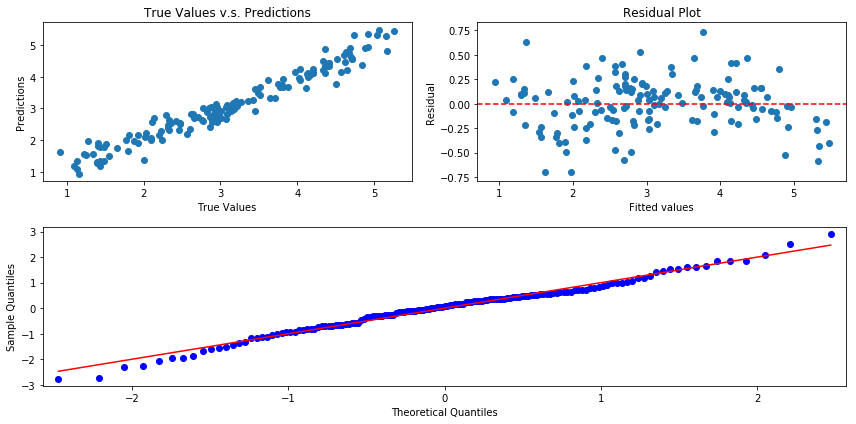

Test R^2: 0.9427479252918104
Test MSE: 0.15682989510308282


In [0]:
fig = plt.figure(figsize = (12,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_train, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

print("Test R^2: " + str(lm.score(X = X_test, y = y_test)))
print("Test MSE: " + str(calculate_mse(y_test, lm.predict(X_test), X_test.shape[0], X_test.shape[1])))

### Normality Tests

In [0]:
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.98932, p=0.325
Sample looks Gaussian (fail to reject H0)


In [0]:
stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.29831, p=4.2839e-12
Sample does not look Gaussian (reject H0)


In [0]:
result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print(f'Alpha at {sl/100}: Critical Value is: {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is: {cv}, data does not look Gaussian (reject H0)')

Statistic: 0.6209211699764694
Alpha at 0.15; Critical Value is: 0.561, data does not look Gaussian (reject H0)
Alpha at 0.1: Critical Value is: 0.639, data looks Gaussian (fail to reject H0)
Alpha at 0.05: Critical Value is: 0.767, data looks Gaussian (fail to reject H0)
Alpha at 0.025: Critical Value is: 0.895, data looks Gaussian (fail to reject H0)
Alpha at 0.01: Critical Value is: 1.064, data looks Gaussian (fail to reject H0)


### Heteroskedasticity test

In [0]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if f_pvalue > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 46.404, p = 2.3399e-10
Variance does not look constant (reject H0)


Results look a little better
- Residuals pass normality test
- Test R^2 is about 1% higher


Need to explain why didn't work.

- Only transformed Y, might affect normality and some other assumption.
- Shape of the distribution of the error terms from the normal distribution and may also lead to substantially differing error term variations


# Lasso Regression

---


There are relatively few countries around the world compared to the amount of data we generate. After some initial wrangling, we only have 182 countries remaining in our dataset, with 15 first order predictors (and 300 if we consider interaction and second order terms!). Low number of observations put us at risk of overfitting the data, which inflates the variance of our model. Feature selection is therefore needed so we won't be using all 15 predictors (or 300). Also, from the correlation matrix presented above, we know that some predictors are highly correlated and are almot linearly dependent. Hence, we are not at risk of increasing bias if we know which ones to throw away.

The Lasso regulisation impose a L1 penalty on the coefficients: every coefficient is being shrinked, and some even as low as zero. This is practically equal to feature selection since feature with zero coefficient has no effect in the model.  

In [0]:
from sklearn.linear_model import Lasso

#呢到Y冇log
lasso_data = worldbank_imputed.copy()

y = lasso_data["Mortality rate, under-5 (per 1,0"]
X = lasso_data.drop(["Mortality rate, under-5 (per 1,0"], axis=1)

In [0]:
alphas = np.logspace(3, -2, 50)*0.5
lasso = Lasso(max_iter=10000, normalize=True, random_state = STAT5102)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(50, 15)

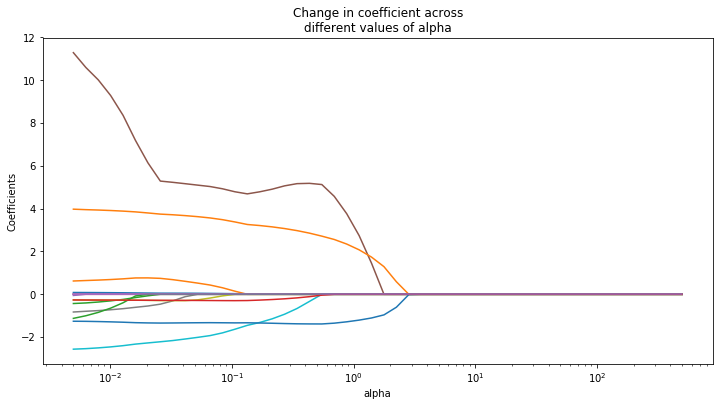

In [0]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title("Change in coefficient across\ndifferent values of alpha")
plt.show()

In [0]:
# Use the cross-validation package to split data into training and test sets
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = STAT5102)

lassocv = LassoCV(alphas=None, cv=5, max_iter=100000, normalize=True, random_state = STAT5102)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_train, y_train)
print("mse = ", calculate_mse(y_test, lasso.predict(X_test), X_test.shape[0], X_test.shape[1]))
print("best model coefficients:")
L1_predictors = pd.Series(lasso.coef_.round(10), index=X.columns)
L1_predictors = L1_predictors[L1_predictors != 0.0]
L1_predictors

Alpha= 0.006481594016861927
mse =  221.57284808991807
best model coefficients:


Adolescent fertility rate (birth               0.062169
Age dependency ratio, old                      0.727984
Age dependency ratio, young                   -0.288773
Agricultural land (% of land are              -0.012446
Fertility rate, total (births pe               8.434462
Health expenditure per capita (c               0.000848
Health expenditure, public (% of              -1.034250
Health expenditure, public _0001              -0.344631
Life expectancy at birth, Gender Difference   -2.540559
Life expectancy at birth, total               -1.463311
Mortality rate, under-5, Gender Difference     3.993149
Population growth (annual %)                  -0.780890
Immunization, DPT (% of children              -0.226950
dtype: float64

There are 13 variables left. 

# Best Subset Selection

---



In [0]:
def fit_linear_reg(X,Y):
    
    n = X.shape[0]
    k = X.shape[1]

    #Fit linear regression model and return MSE and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True, n_jobs=-1)
    model_k.fit(X, Y)

    #get test MSE
    fitted_values = model_k.predict(X)
    MSE = calculate_mse(Y, fitted_values, n, k)
    
    #This implememtation of RSS might be wrong.
    #Because the mean_squared_error simply divides residual by 
    #RSS = mean_squared_error(y_test, fitted_values) * len(y_test)
    
    #get test R^2
    R_squared = model_k.score(X,Y)
    adj_R_squared = 1 - ( (1-R_squared)*(n-1)/(n-(k+1)) )   

    #returning the test RSS and test R^2
    return MSE, adj_R_squared 

In [0]:
print("start")
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools

#Initialization variables
best_subset_data = worldbank_imputed.copy()

#X = best_subset_data.drop("Mortality rate, under-5 (per 1,0", axis=1)

X = best_subset_data[L1_predictors.index]
Y = best_subset_data["Mortality rate, under-5 (per 1,0"].apply(np.log)

MSE_list, adj_R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
#for k in range(1,len(X.columns) + 1):
    print("Now working on ", k, " features!")
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        MSE_list.append(tmp_result[0])                  #Append lists
        adj_R_squared_list.append(tmp_result[1])
        
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
best_sub_features = pd.DataFrame({'numb_features': numb_features,'MSE': MSE_list, 'Adj_R_squared':adj_R_squared_list,'features':feature_list})
print("Done!")


start


Now working on  1  features!
Now working on  2  features!
Now working on  3  features!
Now working on  4  features!
Now working on  5  features!
Now working on  6  features!
Now working on  7  features!
Now working on  8  features!
Now working on  9  features!
Now working on  10  features!
Now working on  11  features!
Now working on  12  features!
Now working on  13  features!

Done!


In [0]:
print("There is a total of", best_sub_features.shape[0], "subsets.")

There is a total of 8191 subsets.


In [0]:
min_MSE = best_sub_features[best_sub_features.groupby('numb_features')['MSE'].transform(min) == best_sub_features['MSE']]
max_adj_R2 = best_sub_features[best_sub_features.groupby('numb_features')['Adj_R_squared'].transform(max) == best_sub_features['Adj_R_squared']]
display(min_MSE.head(3))
display(max_adj_R2.head(3))

,numb_features,MSE,Adj_R_squared,features,min_MSE,max_R_squared
10,1,0.212447,0.843414,"(Mortality rate, under-5, Gender Difference,)",0.212447,0.843414
33,2,0.139862,0.896913,"(Age dependency ratio, old, Mortality rate, un...",0.139862,0.896913
206,3,0.098891,0.927112,"(Age dependency ratio, old, Life expectancy at...",0.098891,0.927112


,numb_features,MSE,Adj_R_squared,features,min_MSE,max_R_squared
10,1,0.212447,0.843414,"(Mortality rate, under-5, Gender Difference,)",0.212447,0.843414
33,2,0.139862,0.896913,"(Age dependency ratio, old, Mortality rate, un...",0.139862,0.896913
206,3,0.098891,0.927112,"(Age dependency ratio, old, Life expectancy at...",0.098891,0.927112


The two look very similar. If we compare the two dataframes, we see that the two dataframes are identical. This tells us that for a given K (number of features), the subset with the lowest MSE is also the subset with the highest adjusted $R^2$. 

In [0]:
all(min_MSE == max_adj_R2)

True

There are numerous combinations for every number of features (e.g. 13 combinations when K == 1). We must select the 'best' subset out of 8191 subsets. 



Next, for every K (from 1 to 13),  we pick out the subset with smallest test MSE, then store it in a dataframe. We also pick out the subset with highest test adjusted $R^2$, and store them in another dataframe. 
We then sort the two data frames by adjusted  $R^2$ and MSE.

In [0]:
display(max_adj_R2.drop(['MSE'], axis = 1).sort_values(by=['Adj_R_squared'], ascending = False))
display(min_MSE.drop(['Adj_R_squared'], axis = 1).sort_values(by=['MSE'], ascending = True))

,numb_features,Adj_R_squared,features
8132,11,0.946382,"(Adolescent fertility rate (birth, Age depende..."
8185,12,0.946249,"(Adolescent fertility rate (birth, Age depende..."
8190,13,0.946107,"(Adolescent fertility rate (birth, Age depende..."
7930,10,0.946056,"(Adolescent fertility rate (birth, Age depende..."
7290,9,0.945417,"(Adolescent fertility rate (birth, Age depende..."
6041,8,0.944846,"(Adolescent fertility rate (birth, Age depende..."
5249,7,0.943943,"(Age dependency ratio, old, Age dependency rat..."
3343,6,0.943293,"(Age dependency ratio, old, Age dependency rat..."
1666,5,0.942298,"(Age dependency ratio, old, Age dependency rat..."
841,4,0.935323,"(Age dependency ratio, young, Health expenditu..."


,numb_features,MSE,features
8132,11,0.072745,"(Adolescent fertility rate (birth, Age depende..."
8185,12,0.072927,"(Adolescent fertility rate (birth, Age depende..."
8190,13,0.073119,"(Adolescent fertility rate (birth, Age depende..."
7930,10,0.073188,"(Adolescent fertility rate (birth, Age depende..."
7290,9,0.074056,"(Adolescent fertility rate (birth, Age depende..."
6041,8,0.074829,"(Adolescent fertility rate (birth, Age depende..."
5249,7,0.076055,"(Age dependency ratio, old, Age dependency rat..."
3343,6,0.076937,"(Age dependency ratio, old, Age dependency rat..."
1666,5,0.078286,"(Age dependency ratio, old, Age dependency rat..."
841,4,0.087750,"(Age dependency ratio, young, Health expenditu..."


In [0]:
best_subset_features = min_MSE[min_MSE["numb_features"] == 5]["features"].tolist()
best_subset_features = list(best_subset_features[0])
best_subset_features

['Age dependency ratio, old',
 'Age dependency ratio, young',
 'Health expenditure per capita (c',
 'Life expectancy at birth, total',
 'Mortality rate, under-5, Gender Difference']

## Plotting the best subset selection process

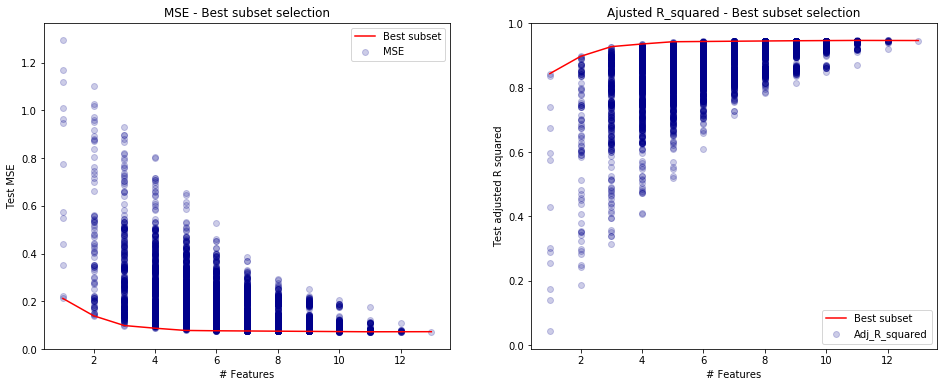

In [0]:
#Adding columns to the dataframe with MSE and R squared values of the best subset
best_sub_features['min_MSE'] = best_sub_features.groupby('numb_features')['MSE'].transform(min)
best_sub_features['max_R_squared'] = best_sub_features.groupby('numb_features')['Adj_R_squared'].transform(max)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(best_sub_features.numb_features,best_sub_features.MSE, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('Test MSE')
ax.set_title('MSE - Best subset selection')
ax.plot(best_sub_features.numb_features, best_sub_features.min_MSE,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(best_sub_features.numb_features,best_sub_features.Adj_R_squared, alpha = .2, color = 'darkblue' )
ax.plot(best_sub_features.numb_features,best_sub_features.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('Test adjusted R squared')
ax.set_title('Ajusted R_squared - Best subset selection')
ax.legend()

plt.show()

# Variance Inflation Factor

Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response. Multicollinearity was measured by variance inflation factors (VIF) and tolerance. If VIF value exceeding 4.0, or by tolerance less than 0.2 then there is a problem with multicollinearity (Hair et al., 2010).

做完Best Subset之後先用VIF黎check淨低果啲predictors

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif_(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]


In [0]:
X = multi_reg_data[best_subset_features].copy()

In [0]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF,features
0,8.713956,"Age dependency ratio, old"
1,15.087836,"Age dependency ratio, young"
2,2.428034,Health expenditure per capita (c
3,15.973198,"Life expectancy at birth, total"
4,7.503002,"Mortality rate, under-5, Gender Difference"


In [0]:
vif_subset = calculate_vif_(X)

dropping 'Life expectancy at birth, total' at index: 3
Remaining variables:
Index(['Age dependency ratio, old', 'Age dependency ratio, young',
       'Health expenditure per capita (c',
       'Mortality rate, under-5, Gender Difference'],
      dtype='object')


In [0]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(vif_subset.values, i) for i in range(vif_subset.shape[1])]
vif["features"] = vif_subset.columns
vif

,VIF,features
0,3.468204,"Age dependency ratio, old"
1,8.978235,"Age dependency ratio, young"
2,2.425127,Health expenditure per capita (c
3,7.280090,"Mortality rate, under-5, Gender Difference"


## Plot Response variable against Best subset predictors

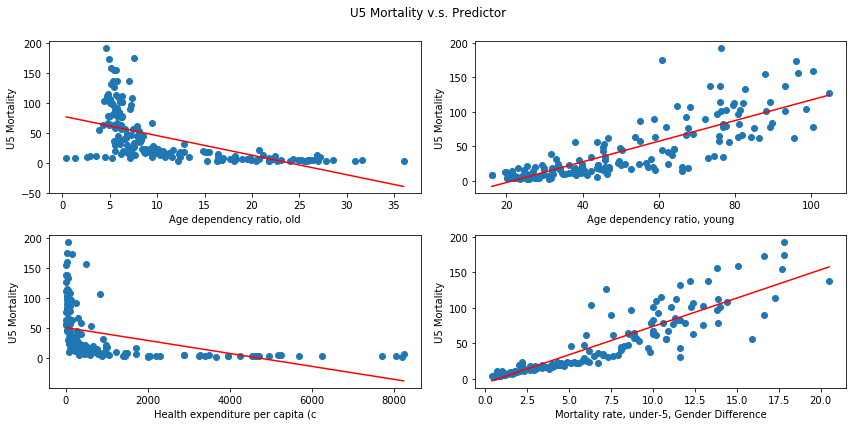

In [0]:
fig = plt.figure(figsize = (12,6))
X = worldbank_imputed.copy()[vif_subset.columns]
Y = worldbank_imputed.copy()["Mortality rate, under-5 (per 1,0"]
for i in range(0, X.shape[1]):
    ax = fig.add_subplot(2,2,i+1)
     
    ax.scatter(X.iloc[:,i], Y)
    ax.set_xlabel(vif_subset.columns.tolist()[i])
    ax.set_ylabel("U5 Mortality")
    
    weights = np.polyfit(X.iloc[:,i], Y, 1)
    model = np.poly1d(weights)
    pred = model(X.iloc[:,i])
    xp = np.linspace(X.iloc[:,i].min(),X.iloc[:,i].max(),100)
    pred_plot = model(xp)
    ax.plot(xp, pred_plot, "r")
    
plt.suptitle("U5 Mortality v.s. Predictor")
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

### Residuals when Y is regressed on each individual predictor

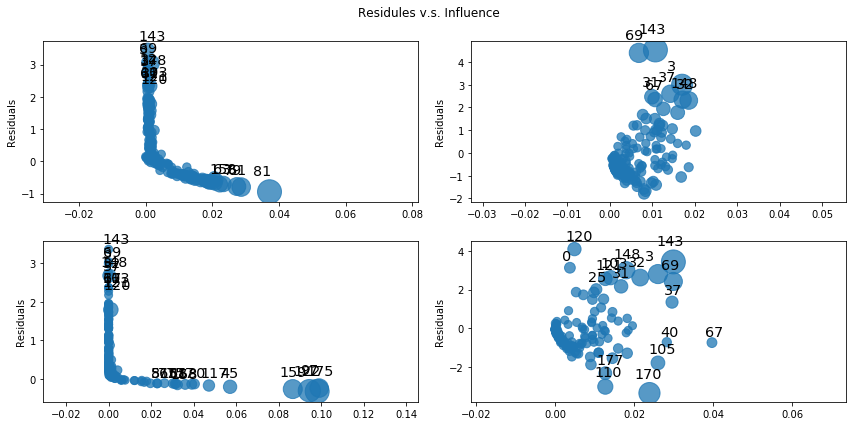

In [0]:
fig = plt.figure(figsize = (12,6))
# plt.xlabel("Influence")
# plt.ylabel("Residual")

for i in range(0, X.shape[1]):
    lm = sm.OLS(Y, X.iloc[:,i]).fit()
    
    ax = fig.add_subplot(2,2,i+1)
    fig = sm.graphics.influence_plot(lm, ax= ax, criterion="cooks", size=24)
    ax.set_xlabel("")
    ax.set_ylabel('Residuals',fontsize=10)
    ax.set_title("")

plt.tight_layout()
plt.suptitle("Residules v.s. Influence")
fig.subplots_adjust(top=0.9)

plt.show()

In [0]:
fig,ax = plt.subplots(figsize = (24,20))
lm = sm.OLS(Y, X.iloc[:,0]).fit()
fig = sm.graphics.influence_plot(lm, ax= ax, criterion="cooks", size=24)


plt.tight_layout()
plt.show()

**There** are a couple of things we can spot here.

- There are serious outliners in Population growth (annual %)
- There is a data point with value greater than 100% in Immunization, DPT (% of children).
- There is polynomial relationship bewteen our response and Life expectancy at birth, Gender Difference

Perhapes we can 

1. transform our predictors a little to give a better fit
1. Remove outliners
1. Remove obviously errornous data point

In [0]:
Polynomial_terms = worldbank_imputed.copy()[vif_subset.columns.tolist() + ["Mortality rate, under-5 (per 1,0"]]

#Log Health expenditure per capita
Polynomial_terms["Health expenditure per capita (c"] = Polynomial_terms["Health expenditure per capita (c"].apply(np.log)

#Remove points with high influence
Polynomial_terms.drop(Polynomial_terms.index[[159, 122, 97, 175, 81, 79, 61]], inplace = True)


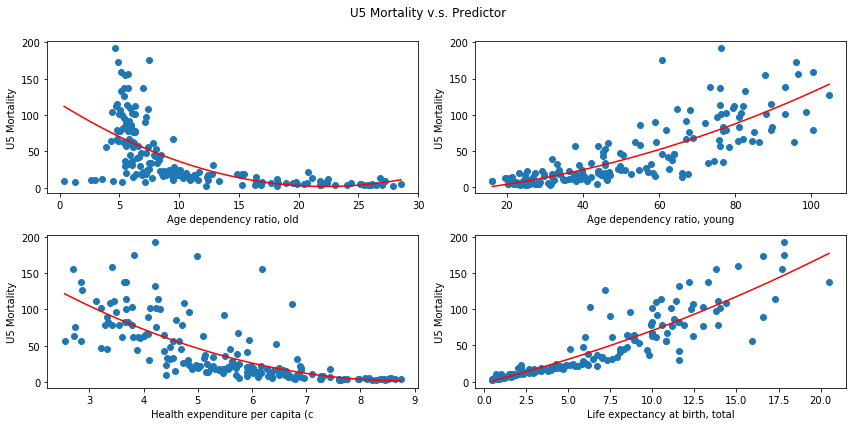

In [0]:
fig = plt.figure(figsize = (12,6))
X = Polynomial_terms.drop("Mortality rate, under-5 (per 1,0", axis = 1)
Y = Polynomial_terms["Mortality rate, under-5 (per 1,0"]
for i in range(0, X.shape[1]):
    ax = fig.add_subplot(2,2,i+1)
     
    ax.scatter(X.iloc[:,i], Y)
    ax.set_xlabel(best_subset_features[i])
    ax.set_ylabel("U5 Mortality")
    
    weights = np.polyfit(X.iloc[:,i], Y, 2)
    model = np.poly1d(weights)
    pred = model(X.iloc[:,i])
    xp = np.linspace(X.iloc[:,i].min(),X.iloc[:,i].max(),100)
    pred_plot = model(xp)
    ax.plot(xp, pred_plot, "r")
    
plt.suptitle("U5 Mortality v.s. Predictor")
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

# Multiple Regression

Use all first order terms

In [0]:
from statsmodels.graphics.gofplots import qqplot

X = Polynomial_terms.drop("Mortality rate, under-5 (per 1,0", axis = 1)
Y = Polynomial_terms["Mortality rate, under-5 (per 1,0"].apply(np.log).values

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
# predictions = lm.predict(X_test)
# residuals = y_test - predictions
# residuals = residuals.flatten()

fitted_values = lm.predict(X_train)
residuals = y_train - fitted_values
residuals = residuals.flatten()

In [0]:
X = X_train
X = sm.add_constant(X)
Y = y_train
lm2 = sm.OLS(Y, X).fit()

xnames = ["Intercept"] + Polynomial_terms.drop("Mortality rate, under-5 (per 1,0", axis = 1).columns.tolist()
print(lm2.summary(xname=xnames, yname = "U5 Mortality Rate"))

print("===============================================================================================================")

N = lm2.nobs
P = lm2.df_model
dfn, dfd = P, N - P - 1
F = lm2.mse_model / lm2.mse_resid
p = 1.0 - scipy.stats.f.cdf(F,dfn,dfd)
print(f'F-statistic: {F:.3f},  p-value: {p:.5f}')

                            OLS Regression Results                            
Dep. Variable:      U5 Mortality Rate   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     456.5
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           9.70e-78
Time:                        18:03:31   Log-Likelihood:                -31.467
No. Observations:                 141   AIC:                             72.93
Df Residuals:                     136   BIC:                             87.68
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

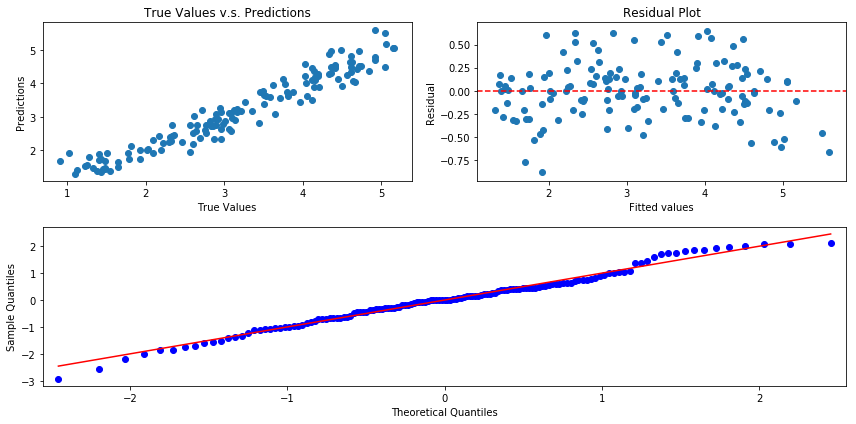

Test R^2: 0.9210744810146482
Test MSE: 0.0861521960775721


In [0]:
fig = plt.figure(figsize = (12,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_train, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

print("Test R^2: " + str(lm.score(X = X_test, y = y_test)))
print("Test MSE: " + str(mean_squared_error(y_test, lm.predict(X_test))))

### Normality Tests

In [0]:
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.98609, p=0.16653
Sample looks Gaussian (fail to reject H0)


In [0]:
stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.26204, p=4.9504e-09
Sample does not look Gaussian (reject H0)


In [0]:
result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print(f'Alpha at {sl/100}: Critical Value is: {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is: {cv}, data does not look Gaussian (reject H0)')

Statistic: 0.5493075696939513
Alpha at 0.15: Critical Value is: 0.561, data looks Gaussian (fail to reject H0)
Alpha at 0.1: Critical Value is: 0.639, data looks Gaussian (fail to reject H0)
Alpha at 0.05: Critical Value is: 0.766, data looks Gaussian (fail to reject H0)
Alpha at 0.025: Critical Value is: 0.894, data looks Gaussian (fail to reject H0)
Alpha at 0.01: Critical Value is: 1.063, data looks Gaussian (fail to reject H0)


### Heteroskedasticity test

In [0]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(lm2.resid, lm2.model.exog)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if f_pvalue > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 1.8963, p = 0.11461
Variance looks constant (fail to reject H0)


## Plot residuals against each variables

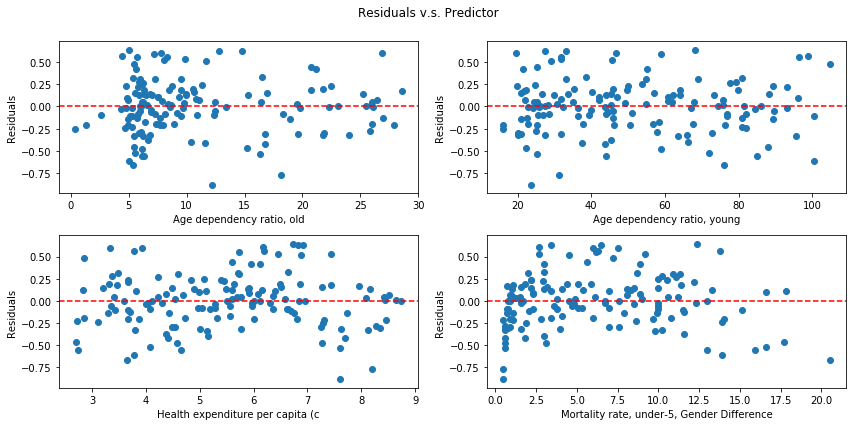

In [0]:
fig = plt.figure(figsize = (12,6))
for i in range(0, X_train.shape[1]):
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_train.iloc[:,i], residuals)
    ax.axhline(y = 0, color='r', linestyle = '--')
    ax.set_xlabel(Polynomial_terms.drop("Mortality rate, under-5 (per 1,0", axis = 1).columns[i])
    ax.set_ylabel("Residuals")
    
    
plt.suptitle("Residuals v.s. Predictor")
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

# Create polynomial features 

---

### See how many polynomial features can there be using the PolynomialFeatures function; to generate quadratic terms for Polynomial regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures

#example
#test PolynomialFeatures function
data = pd.DataFrame.from_dict({
    'x': np.random.randint(low=1, high=10, size=5),
    'y': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=2).fit(data)
p.get_feature_names(data.columns)

['1', 'x', 'y', 'x^2', 'x y', 'y^2']

So a 2-D matrix becomes 5-D after adding second order terms and interaction terms. The transformed data is in the following matrix:

In [0]:
p.transform(data)

array([[ 1.,  3.,  0.,  9.,  0.,  0.],
       [ 1.,  5.,  0., 25.,  0.,  0.],
       [ 1.,  4.,  0., 16.,  0.,  0.],
       [ 1.,  3., -1.,  9., -3.,  1.],
       [ 1.,  5.,  0., 25.,  0.,  0.]])

### Transform our data

In [0]:
#make a copy of our dataset: dont mess with our dataset
#impute data with mean coz PolynomialFeatures function can't work with dataset with missing data
poly = worldbank_imputed.copy()
poly = poly[vif_subset.columns.tolist()]

#have to deal with continent column.
degree = 2
quadratic_terms = PolynomialFeatures(degree = degree, interaction_only=True).fit(poly)
ternames = quadratic_terms.get_feature_names(poly.columns)
num_terms = len(ternames)

#transform data into their corrosponding quadratic form
quadratic_data = quadratic_terms.transform(poly)
quadratic_data = pd.DataFrame(data = quadratic_data)
quadratic_data.rename(columns=dict(zip(quadratic_data.columns,ternames)), inplace=True)
quadratic_data.drop('1', axis = 1, inplace = True)
"There are a total of " + str(num_terms) + " first, second, and interaction terms"

'There are a total of 11 first, second, and interaction terms'

In [0]:
#export world_bank_quadratic to excel file to share with groupmates (19 Nov 2018)
share = 1
if share:
    writer = pd.ExcelWriter('worldbank_quadratic.xlsx')
    quadratic_data.to_excel(writer, 'Sheet1')
    writer.save()

# Variance Inflation Factor on higher order terms

In [0]:
# vifed = calculate_vif_(quadratic_data, 5)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(quadratic_data.values, i) for i in range(quadratic_data.shape[1])]
vif["features"] = quadratic_data.columns
vif

,VIF Factor,features
0,38.258339,"Age dependency ratio, old"
1,57.172713,"Age dependency ratio, young"
2,163.553571,Health expenditure per capita (c
3,93.919444,"Mortality rate, under-5, Gender Difference"
4,127.284814,"Age dependency ratio, old Age dependency ratio..."
5,40.776416,"Age dependency ratio, old Health expenditure p..."
6,47.318931,"Age dependency ratio, old Mortality rate, unde..."
7,99.390045,"Age dependency ratio, young Health expenditure..."
8,31.702015,"Age dependency ratio, young Mortality rate, un..."
9,6.371535,Health expenditure per capita (c Mortality rat...


In [0]:
quadratic_data = calculate_vif_(quadratic_data)

dropping 'Health expenditure per capita (c' at index: 2
dropping 'Age dependency ratio, old Age dependency ratio, young' at index: 3
dropping 'Mortality rate, under-5, Gender Difference' at index: 2
dropping 'Age dependency ratio, young Health expenditure per capita (c' at index: 4
dropping 'Age dependency ratio, young Mortality rate, under-5, Gender Difference' at index: 4
Remaining variables:
Index(['Age dependency ratio, old', 'Age dependency ratio, young',
       'Age dependency ratio, old Health expenditure per capita (c',
       'Age dependency ratio, old Mortality rate, under-5, Gender Difference',
       'Health expenditure per capita (c Mortality rate, under-5, Gender Difference'],
      dtype='object')


# Best Subset Selection for higher order terms

In [0]:
print("start")
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools

#Initialization variables
best_subset_data = worldbank_imputed.copy()

#X = best_subset_data.drop("Mortality rate, under-5 (per 1,0", axis=1)

X = quadratic_data
Y = best_subset_data["Mortality rate, under-5 (per 1,0"].apply(np.log)

MSE_list, adj_R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
#for k in range(1,len(X.columns) + 1):
    print("Now working on ", k, " features!")
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        MSE_list.append(tmp_result[0])                  #Append lists
        adj_R_squared_list.append(tmp_result[1])
        
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
best_sub_features2 = pd.DataFrame({'numb_features': numb_features,'MSE': MSE_list, 'Adj_R_squared':adj_R_squared_list,'features':feature_list})
print("Done!")

start


Now working on  1  features!
Now working on  2  features!
Now working on  3  features!
Now working on  4  features!
Now working on  5  features!
Now working on  6  features!
Now working on  7  features!
Now working on  8  features!
Now working on  9  features!
Now working on  10  features!

Done!


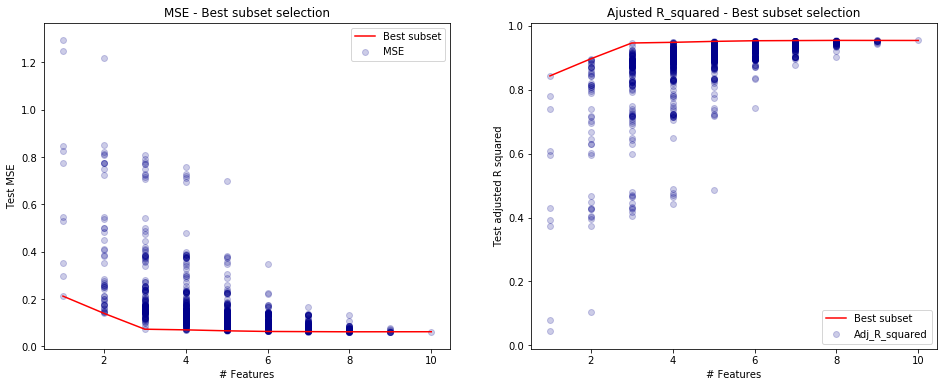

In [0]:
#Adding columns to the dataframe with MSE and R squared values of the best subset
best_sub_features2['min_MSE'] = best_sub_features2.groupby('numb_features')['MSE'].transform(min)
best_sub_features2['max_R_squared'] = best_sub_features2.groupby('numb_features')['Adj_R_squared'].transform(max)

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(best_sub_features2.numb_features,best_sub_features2.MSE, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('Test MSE')
ax.set_title('MSE - Best subset selection')
ax.plot(best_sub_features2.numb_features, best_sub_features2.min_MSE,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(best_sub_features2.numb_features,best_sub_features2.Adj_R_squared, alpha = .2, color = 'darkblue' )
ax.plot(best_sub_features2.numb_features,best_sub_features2.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('Test adjusted R squared')
ax.set_title('Ajusted R_squared - Best subset selection')
ax.legend()

plt.show()

In [0]:
min_MSE = best_sub_features2[best_sub_features2.groupby('numb_features')['MSE'].transform(min) == best_sub_features2['MSE']]
max_adj_R2 = best_sub_features2[best_sub_features2.groupby('numb_features')['Adj_R_squared'].transform(max) == best_sub_features2['Adj_R_squared']]
display(min_MSE.head(3))
display(max_adj_R2.head(3))

,numb_features,MSE,Adj_R_squared,features
3,1,0.212447,0.843414,"(Mortality rate, under-5, Gender Difference,)"
12,2,0.139862,0.896913,"(Age dependency ratio, old, Mortality rate, un..."
105,3,0.072684,0.946428,"(Age dependency ratio, young, Age dependency r..."


,numb_features,MSE,Adj_R_squared,features
3,1,0.212447,0.843414,"(Mortality rate, under-5, Gender Difference,)"
12,2,0.139862,0.896913,"(Age dependency ratio, old, Mortality rate, un..."
105,3,0.072684,0.946428,"(Age dependency ratio, young, Age dependency r..."


In [0]:
# display(max_adj_R2.drop(['MSE'], axis = 1).sort_values(by=['Adj_R_squared'], ascending = False))
display(min_MSE.drop(['Adj_R_squared'], axis = 1).sort_values(by=['MSE'], ascending = True))

,numb_features,MSE,features
1010,8,0.061713,"(Age dependency ratio, young, Mortality rate, ..."
1019,9,0.061815,"(Age dependency ratio, old, Age dependency rat..."
1022,10,0.061977,"(Age dependency ratio, old, Age dependency rat..."
869,7,0.062431,"(Age dependency ratio, old, Age dependency rat..."
785,6,0.063095,"(Age dependency ratio, young, Health expenditu..."
573,5,0.065883,"(Age dependency ratio, young, Age dependency r..."
299,4,0.069900,"(Age dependency ratio, young, Age dependency r..."
105,3,0.072684,"(Age dependency ratio, young, Age dependency r..."
12,2,0.139862,"(Age dependency ratio, old, Mortality rate, un..."
3,1,0.212447,"(Mortality rate, under-5, Gender Difference,)"


In [0]:
best_subset_features2 = min_MSE[min_MSE["numb_features"] == 4]["features"].tolist()
best_subset_features2 = list(best_subset_features2[0])
best_subset_features2

['Age dependency ratio, young',
 'Age dependency ratio, old Age dependency ratio, young',
 'Age dependency ratio, old Mortality rate, under-5, Gender Difference',
 'Age dependency ratio, young Health expenditure per capita (c']

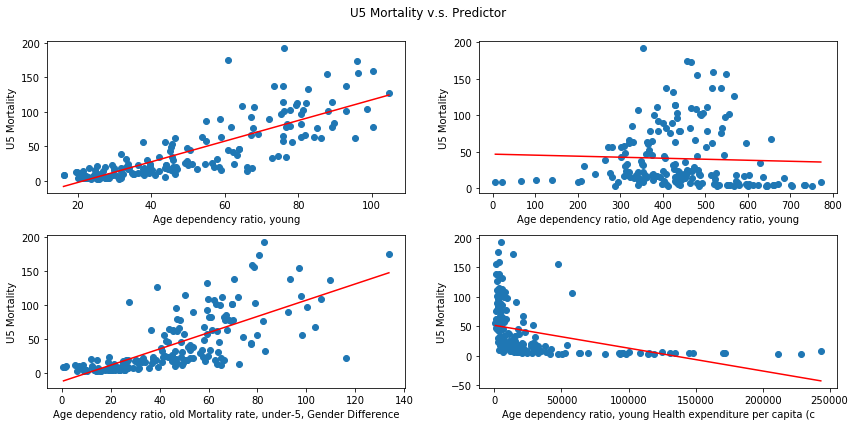

In [0]:
fig = plt.figure(figsize = (12,6))
X = quadratic_data.copy()[best_subset_features2]
Y = worldbank_imputed.copy()["Mortality rate, under-5 (per 1,0"]
for i in range(0, X.shape[1]):
    ax = fig.add_subplot(2,2,i+1)
     
    ax.scatter(X.iloc[:,i], Y)
    ax.set_xlabel(best_subset_features2[i])
    ax.set_ylabel("U5 Mortality")
    
    weights = np.polyfit(X.iloc[:,i], Y, 1)
    model = np.poly1d(weights)
    pred = model(X.iloc[:,i])
    xp = np.linspace(X.iloc[:,i].min(),X.iloc[:,i].max(),100)
    pred_plot = model(xp)
    ax.plot(xp, pred_plot, "r")
    
plt.suptitle("U5 Mortality v.s. Predictor")
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [0]:
multi_reg_data = worldbank_imputed.copy()


X_train, X_test, y_train, y_test = train_test_split(quadratic_data[best_subset_features2], 
                                                    multi_reg_data["Mortality rate, under-5 (per 1,0"].apply(np.log).values, 
                                                    test_size=0.1, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
# predictions = lm.predict(X_test)
# residuals = y_test - predictions
# residuals = residuals.flatten()

fitted_values = lm.predict(X_train)
residuals = y_train - fitted_values
residuals = residuals.flatten()

In [0]:
X = X_train
X = sm.add_constant(X)
Y = y_train
lm2 = sm.OLS(Y, X).fit()

xnames = ["Intercept"] + quadratic_data[best_subset_features2].columns.tolist()
print(lm2.summary(xname=xnames, yname = "U5 Mortality Rate"))

print("===============================================================================================================")

N = lm2.nobs
P = lm2.df_model
dfn, dfd = P, N - P - 1
F = lm2.mse_model / lm2.mse_resid
p = 1.0 - scipy.stats.f.cdf(F,dfn,dfd)
print(f'F-statistic: {F:.3f},  p-value: {p:.5f}')

                            OLS Regression Results                            
Dep. Variable:      U5 Mortality Rate   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     690.4
Date:                Fri, 14 Dec 2018   Prob (F-statistic):          9.19e-100
Time:                        18:10:29   Log-Likelihood:                -16.203
No. Observations:                 165   AIC:                             42.41
Df Residuals:                     160   BIC:                             57.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

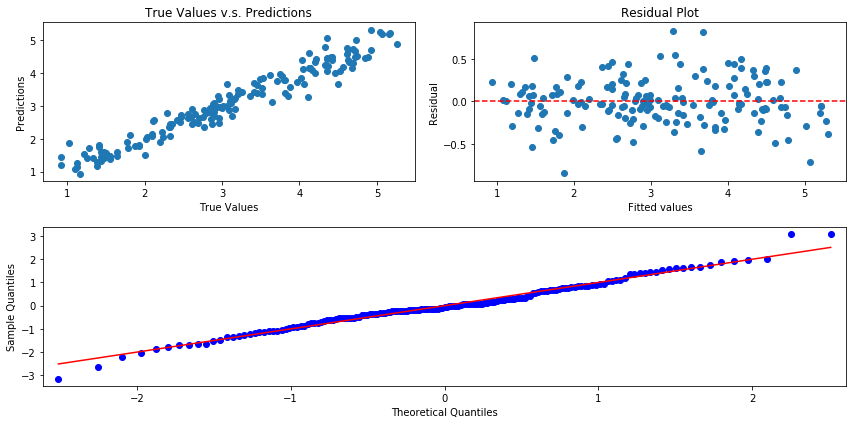

Test R^2: 0.9766619023298264
Test MSE: 0.0412241492993151


In [0]:
fig = plt.figure(figsize = (12,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_train, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

print("Test R^2: " + str(lm.score(X = X_test, y = y_test)))
print("Test MSE: " + str(mean_squared_error(y_test, lm.predict(X_test))))

### Normality Tests

In [0]:
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.98816, p=0.17968
Sample looks Gaussian (fail to reject H0)


In [0]:
stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.28922, p=1.0236e-12
Sample does not look Gaussian (reject H0)


In [0]:
result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic.any() < result.critical_values[i]:
        print(f'Alpha at {sl/100}: Critical Value is: {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is: {cv}, data does not look Gaussian (reject H0)')

Statistic: 0.7392844431015533
Alpha at 0.15; Critical Value is: 0.563, data does not look Gaussian (reject H0)
Alpha at 0.1; Critical Value is: 0.641, data does not look Gaussian (reject H0)
Alpha at 0.05; Critical Value is: 0.769, data does not look Gaussian (reject H0)
Alpha at 0.025; Critical Value is: 0.897, data does not look Gaussian (reject H0)
Alpha at 0.01: Critical Value is: 1.067, data looks Gaussian (fail to reject H0)


### Heteroskedasticity test

In [0]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if f_pvalue > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 57.997, p = 1.9723e-12
Variance does not look constant (reject H0)
